In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import keras
import tensorflow as tf
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array, array_to_img
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, MaxPool2D, Conv2D, GlobalAveragePooling2D, BatchNormalization, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split

import seaborn as sns

2024-02-27 14:58:26.641396: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 14:58:26.641637: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 14:58:26.864861: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Loading data

In [2]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
sub = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')
print("Data are Ready!!")

Data are Ready!!


In [3]:
print(f"Training data size is {train.shape}\nTesting data size is {test.shape}")

Training data size is (42000, 785)
Testing data size is (28000, 784)


In [4]:
train.label.value_counts()


label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='count'>

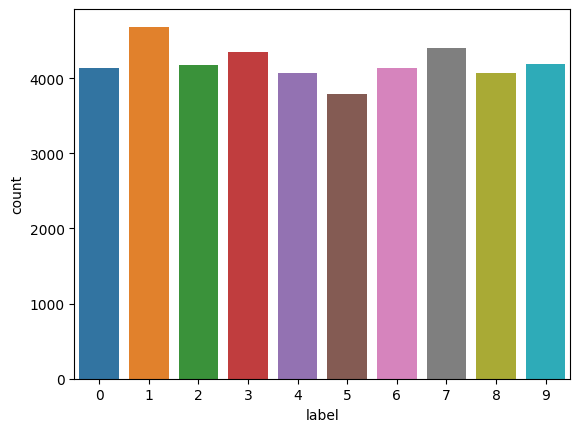

In [5]:
sns.countplot(train, x='label')

In [6]:
X = train.drop(['label'], axis=1).values
y = train['label'].values

X.shape

(42000, 784)

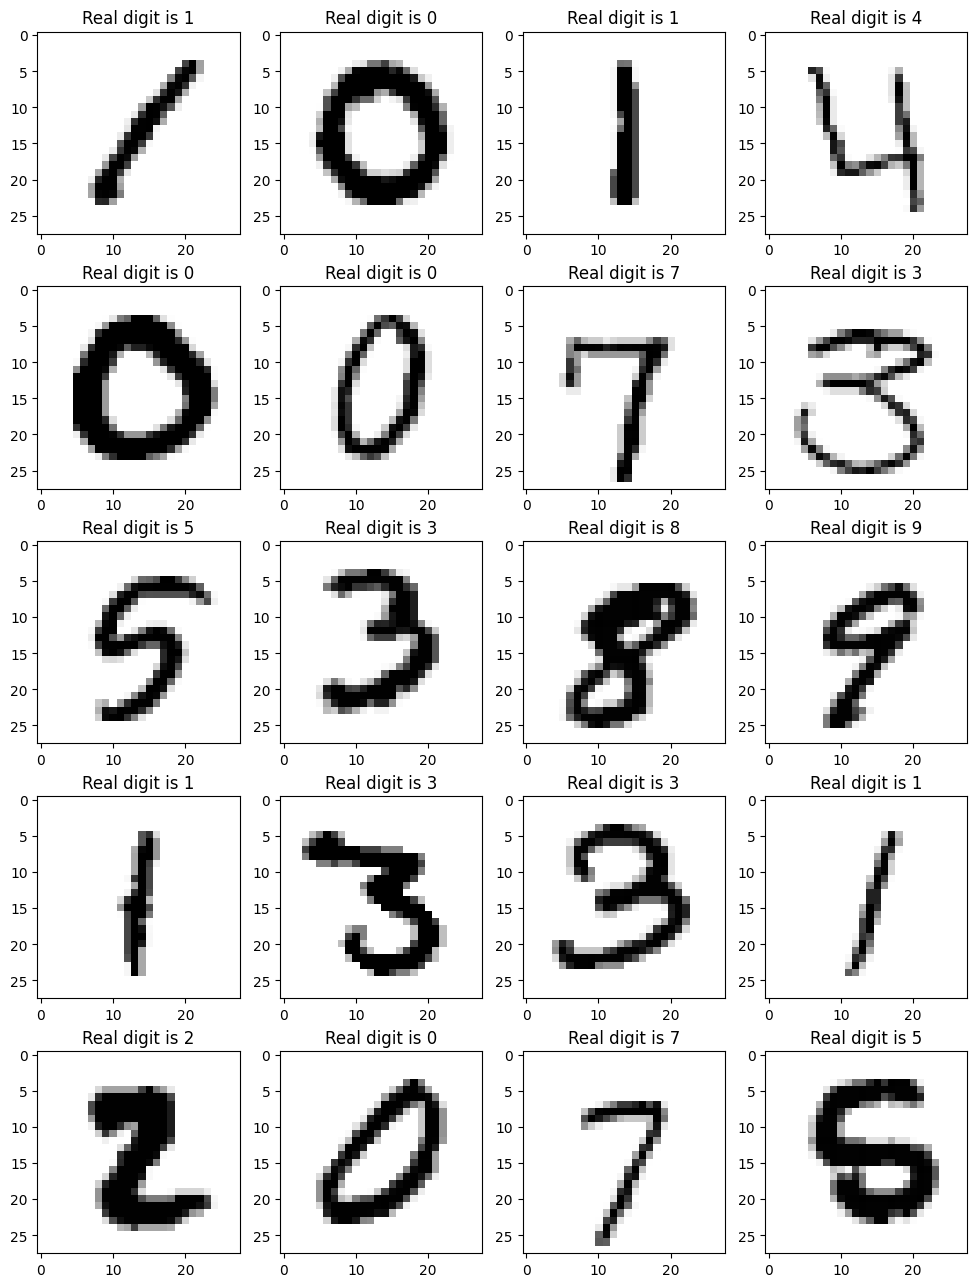

In [7]:
fig, axis = plt.subplots(5, 4, figsize=(12,16))

for i, ax in enumerate(axis.flat):
    ax.imshow(X[i].reshape(28, 28), cmap='binary')
    ax.set(title = "Real digit is {}".format(y[i]))

# Normalization, Reshape and Label Encoding

Train and test images (28px x 28px) has been stock into pandas.Dataframe as 1D vectors of 784 values. We reshape all data to 28x28x1 3D matrices.

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one channel. For RGB images, there is 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matrices.

In [8]:
X = X.reshape(-1,28,28,1)

print("x_train shape: ",X.shape)


x_train shape:  (42000, 28, 28, 1)


We perform a grayscale normalization to reduce the effect of illumination's differences.

Moreover the CNN converg faster on [0..1] data than on [0..255].

In [9]:
X = X / 255.0
print("x shape: ",X.shape)


x shape:  (42000, 28, 28, 1)


In [10]:
len(y)

42000

Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]).

In [11]:
y = to_categorical(y, num_classes=10)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [13]:
print(f'X_train_shape: {X_train.shape}, y_train_shape: {y_train.shape}')
print(f'X_test_shape: {X_test.shape}, y_test_shape: {y_test.shape}')

X_train_shape: (37800, 28, 28, 1), y_train_shape: (37800, 10)
X_test_shape: (4200, 28, 28, 1), y_test_shape: (4200, 10)


# Building model

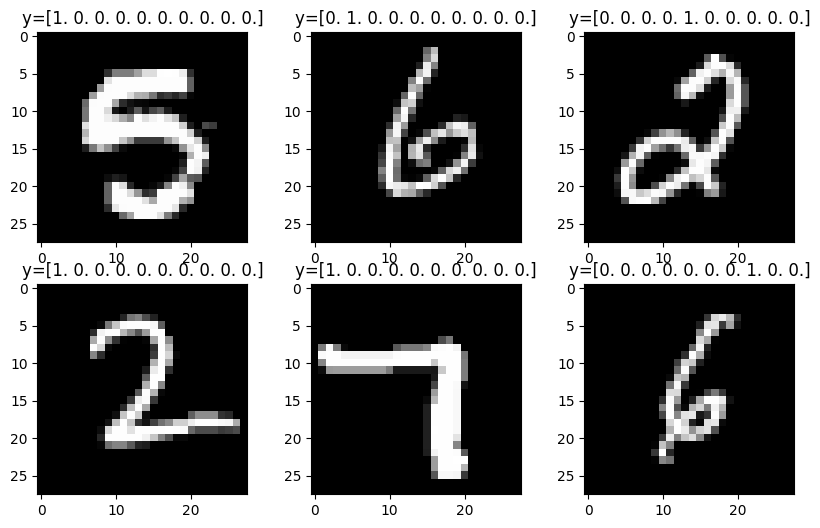

In [14]:

plt.figure(figsize=(10, 6))  # Define figure size
for i in range(1, 7):  # Loop for 2x3 grid
    plt.subplot(2, 3, i)  # Create subplot
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    plt.title('y={}'.format(y[i]))
plt.show()  # Display the plot


In [15]:
def create_model():

    model=Sequential()

#model.add(Lambda(standardize,input_shape=(28,28,1)))    
    model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))
    model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
    model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())    

    model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dense(512,activation="relu"))
    
    model.add(Dense(10,activation="softmax"))
    
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model

In [16]:
model = create_model()

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 12, 12, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         1

In [18]:
epochs = 10
batch_size = 64
train_steps = X_train.shape[0] // batch_size
valid_steps = X_test.shape[0] // batch_size
    

es = keras.callbacks.EarlyStopping(
        monitor="val_acc", # metrics to monitor
        patience=10, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True, # 
     )

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [19]:
history = model.fit(X_train, y_train, batch_size=128, epochs=10, callbacks=[learning_rate_reduction])

Epoch 1/10
296/296 [==============================] - 120s 396ms/step - loss: 0.1020 - accuracy: 0.9684 - lr: 0.0010
Epoch 2/10
296/296 [==============================] - 117s 396ms/step - loss: 0.0368 - accuracy: 0.9888 - lr: 0.0010
Epoch 3/10
296/296 [==============================] - 117s 396ms/step - loss: 0.0254 - accuracy: 0.9922 - lr: 0.0010
Epoch 4/10
296/296 [==============================] - 117s 397ms/step - loss: 0.0180 - accuracy: 0.9941 - lr: 0.0010
Epoch 5/10
296/296 [==============================] - 118s 398ms/step - loss: 0.0179 - accuracy: 0.9944 - lr: 0.0010
Epoch 6/10
296/296 [==============================] - 117s 395ms/step - loss: 0.0114 - accuracy: 0.9962 - lr: 0.0010
Epoch 7/10
296/296 [==============================] - 118s 398ms/step - loss: 0.0125 - accuracy: 0.9961 - lr: 0.0010
Epoch 8/10
296/296 [==============================] - 117s 395ms/step - loss: 0.0110 - accuracy: 0.9960 - lr: 0.0010
Epoch 9/10
296/296 [==============================] - 116s 393ms

In [20]:
# Plot history
def plot_advanced_history(history):
    fig, axs = plt.subplots(2)

    # Plot training & validation loss values
    axs[0].plot(history.history['loss'], label='Training Loss')
#     axs[0].plot(history.history['val_loss'], label='Validation Loss')
    axs[0].set_title('Model Loss')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].legend()

    # Plot training & validation accuracy values
    axs[1].plot(history.history['accuracy'], label='Training Accuracy')
#     axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[1].set_title('Model Accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

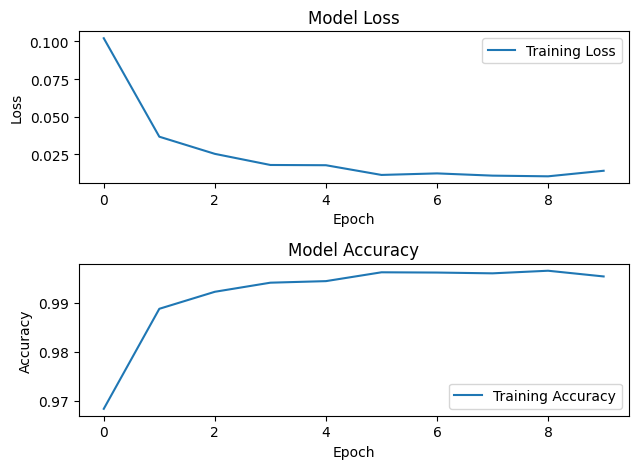

In [21]:
plot_advanced_history(history)

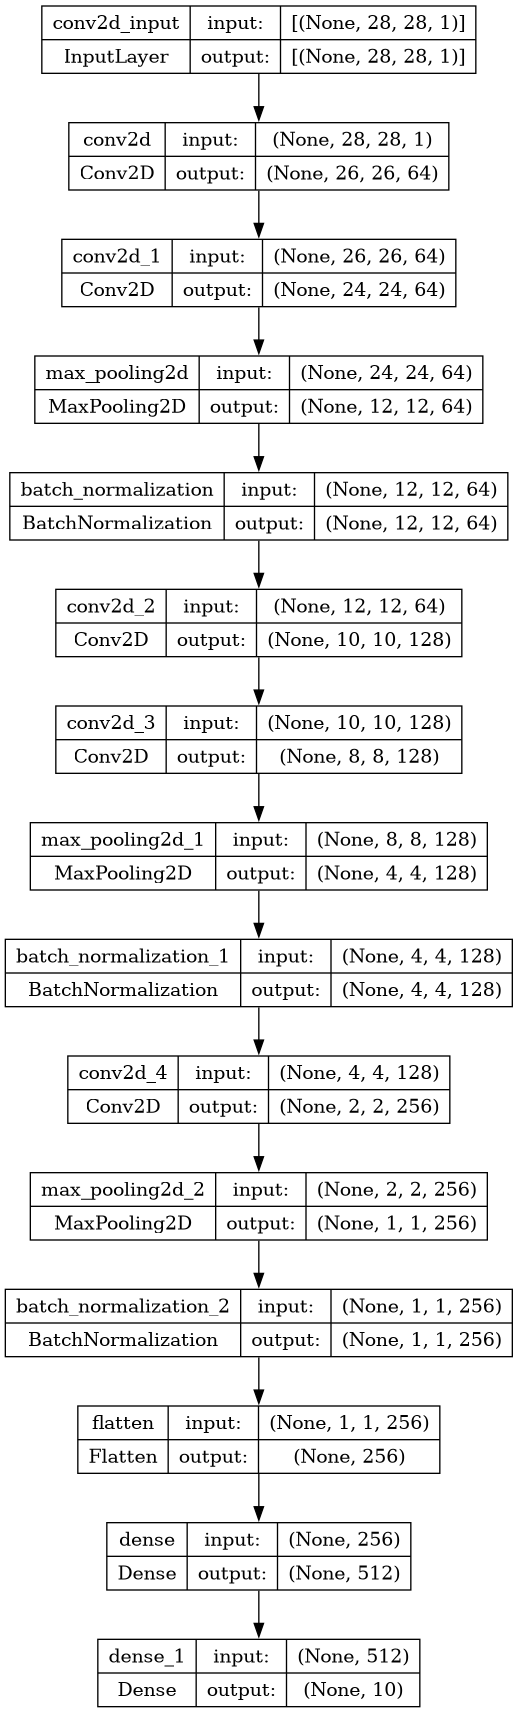

In [22]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)


In [23]:
results = model.predict(X_test, batch_size=128)
results = np.argmax(results, axis=1)

33/33 [==============================] - 3s 98ms/step


In [24]:
model.evaluate(X_test, y_test)

132/132 [==============================] - 4s 30ms/step - loss: 0.0353 - accuracy: 0.9912


[0.03533094376325607, 0.991190493106842]

In [25]:
results

array([8, 1, 9, ..., 7, 7, 5])

In [26]:
X_train_original = X_train.reshape(-1, 28, 28)
X_test_original = X_test.reshape(-1, 28, 28)

In [27]:
y_test_original = np.argmax(y_test, axis=1)

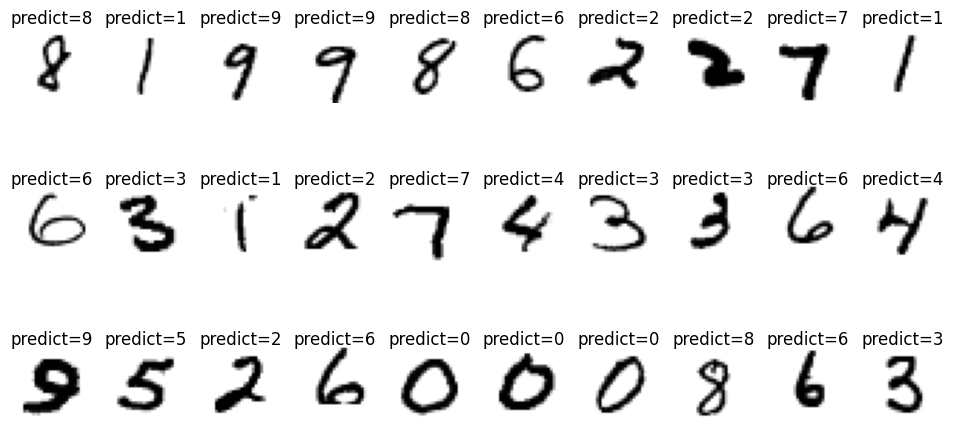

In [28]:
plt.figure(figsize=(12,8))

for i in range(30):
  plt.subplot(4,10, i+1)
  plt.imshow(X_test_original[i], cmap=plt.cm.binary)
  plt.title("predict=%d" % results[i], y=0.9)
  plt.axis('off')
plt.show()

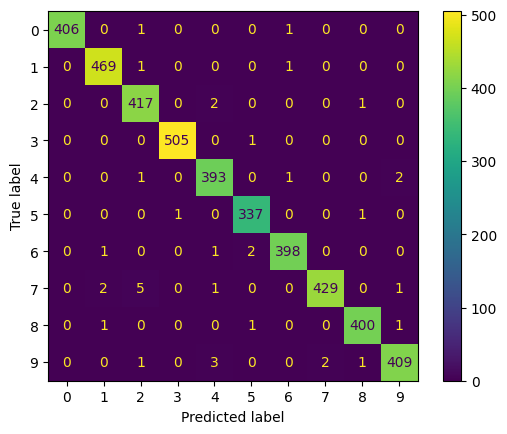

In [29]:
cm = confusion_matrix(y_test_original, results)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [30]:
accuracy_score(y_test_original, results)

0.9911904761904762

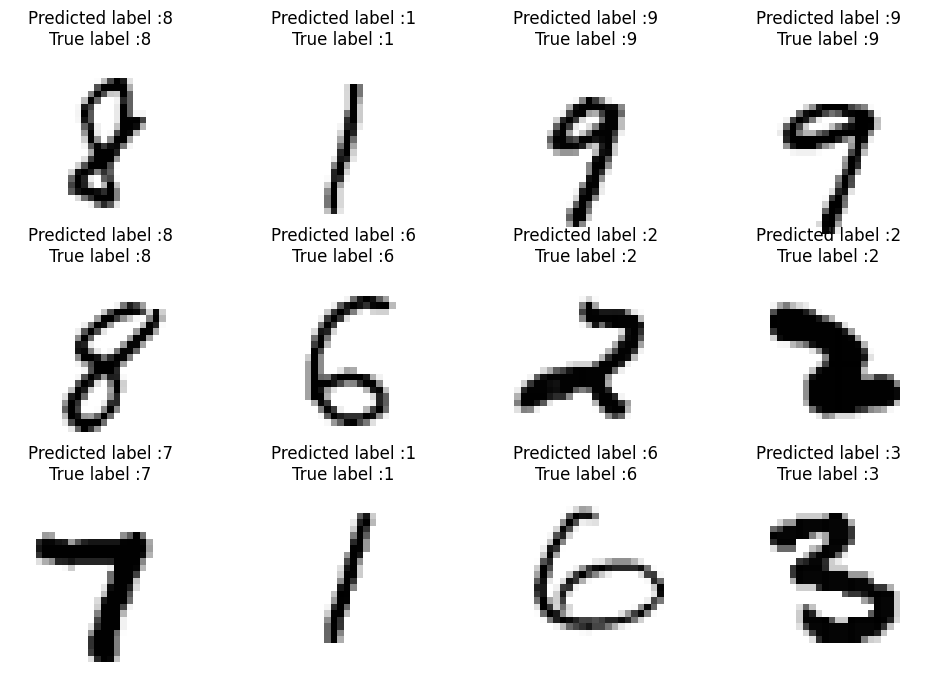

In [31]:
plt.figure(figsize=(12,8))
for i in range(12):
    plt.subplot(3,4, i+1)
    plt.imshow(X_test_original[i], cmap=plt.cm.binary)
    plt.title("Predicted label :{}\nTrue label :{}".format(results[i], y_test_original[i]))
    plt.axis('off')

# Training model with data augmentation

In [42]:
X_train_val_aug, X_test_aug, y_train_val_aug, y_test_aug = train_test_split(X, y, test_size=0.2, random_state=42, )

In [43]:
X_train_aug, X_val_aug, y_train_aug, y_val_aug = train_test_split(X_train_val_aug, y_train_val_aug, test_size=0.15, random_state=42)

In [44]:
print(f'X_train_shape: {X_train_aug.shape}, y_train_shape: {y_train_aug.shape}')
print(f'X_val_shape: {X_val_aug.shape}, y_val_shape: {y_val_aug.shape}')
print(f'X_test_shape: {X_test_aug.shape}, y_test_shape: {y_test_aug.shape}')

X_train_shape: (28560, 28, 28, 1), y_train_shape: (28560, 10)
X_val_shape: (5040, 28, 28, 1), y_val_shape: (5040, 10)
X_test_shape: (8400, 28, 28, 1), y_test_shape: (8400, 10)


In [46]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.1,
                             rotation_range=15)

In [47]:
datagen.fit(X_train_aug)

In [48]:
val_datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.1,
                             rotation_range=15)

In [49]:
val_datagen.fit(X_val_aug)

In [50]:
model_aug = create_model()

In [51]:
model_aug.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 26, 26, 64)        640       
                                                                 
 conv2d_11 (Conv2D)          (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization_6 (Bat  (None, 12, 12, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_12 (Conv2D)          (None, 10, 10, 128)       73856     
                                                                 
 conv2d_13 (Conv2D)          (None, 8, 8, 128)        

In [52]:
model_aug.fit(datagen.flow(X_train_aug, y_train_aug, batch_size=batch_size),
                        epochs=10, 
                        verbose=1,
                        validation_data=(X_val_aug, y_val_aug),
                        callbacks=[learning_rate_reduction])

Epoch 1/10
447/447 [==============================] - 101s 221ms/step - loss: 0.1922 - accuracy: 0.9411 - val_loss: 0.1454 - val_accuracy: 0.9607 - lr: 0.0010
Epoch 2/10
447/447 [==============================] - 99s 221ms/step - loss: 0.0829 - accuracy: 0.9749 - val_loss: 0.0872 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 3/10
447/447 [==============================] - 98s 220ms/step - loss: 0.0713 - accuracy: 0.9777 - val_loss: 0.0432 - val_accuracy: 0.9885 - lr: 0.0010
Epoch 4/10
447/447 [==============================] - 98s 220ms/step - loss: 0.0547 - accuracy: 0.9837 - val_loss: 0.0598 - val_accuracy: 0.9857 - lr: 0.0010
Epoch 5/10
447/447 [==============================] - 98s 220ms/step - loss: 0.0549 - accuracy: 0.9825 - val_loss: 0.0596 - val_accuracy: 0.9835 - lr: 0.0010
Epoch 6/10
447/447 [==============================] - ETA: 0s - loss: 0.0497 - accuracy: 0.9851
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
447/447 [============================

In [53]:
model_aug.evaluate(X_test_aug, y_test_aug)

263/263 [==============================] - 8s 29ms/step - loss: 0.0636 - accuracy: 0.9820


[0.06358256936073303, 0.9820238351821899]

In [54]:
results = model_aug.predict(X_test_aug, batch_size=128)
results = np.argmax(results, axis=1)

66/66 [==============================] - 7s 99ms/step


In [55]:
X_test_original_aug = X_test_aug.reshape(-1,28,28)
X_train_original_aug = X_train_aug.reshape(-1,28,28)

In [56]:
y_test_aug_original = np.argmax(y_test_aug, axis=1)

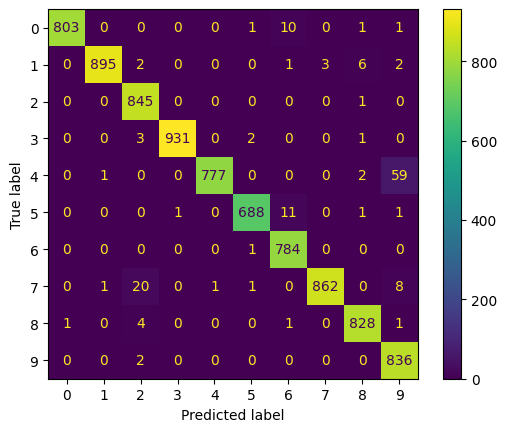

In [57]:
cm = confusion_matrix(y_test_aug_original, results)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()


We can note that, all other training conditions being equal, the model with image augmentation gives a better result

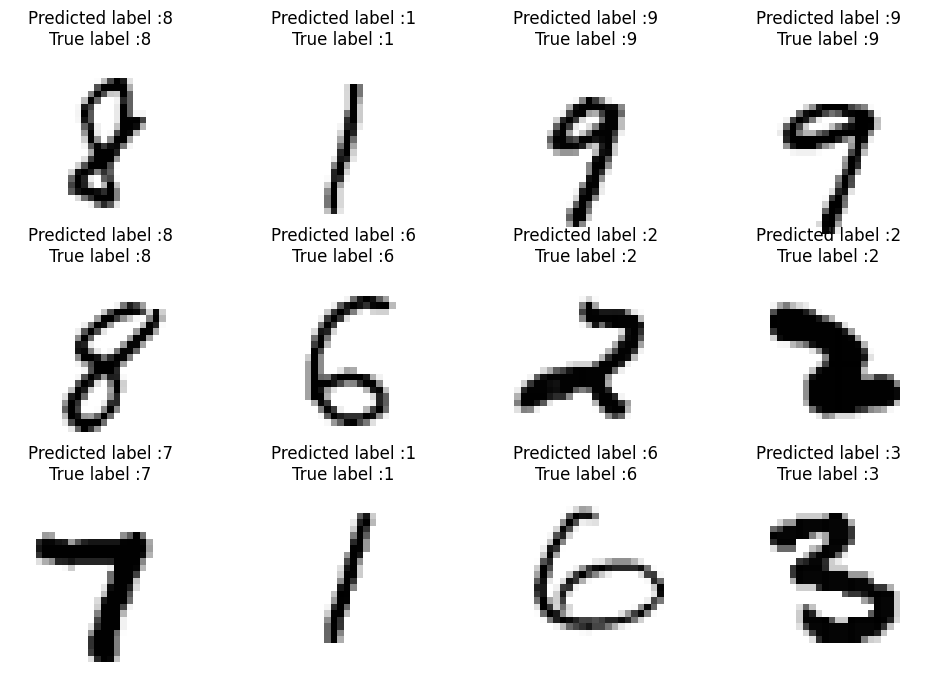

In [58]:
plt.figure(figsize=(12,8))
for i in range(12):
    plt.subplot(3,4, i+1)
    plt.imshow(X_test_original_aug[i], cmap=plt.cm.binary)
    plt.title("Predicted label :{}\nTrue label :{}".format(results[i],y_test_aug_original[i]))
    plt.axis('off')

In [59]:
accuracy_score(results, y_test_aug_original)

0.9820238095238095